## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/0001TP_008160.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0016E5_08041.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0006R0_f02340.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05400_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0006R0_f02640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05340_P.png')]

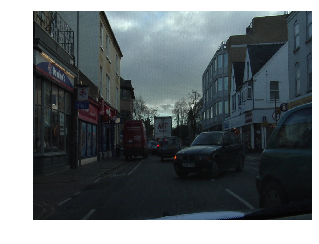

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

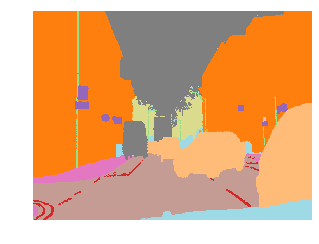

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
mask.shape,mask.data

(torch.Size([1, 720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size=640
bs=4

In [13]:
data = (ImageFileList.from_folder(path_img)
        .label_from_func(get_y_fn)
        .split_by_fname_file('../valid.txt')
        .datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

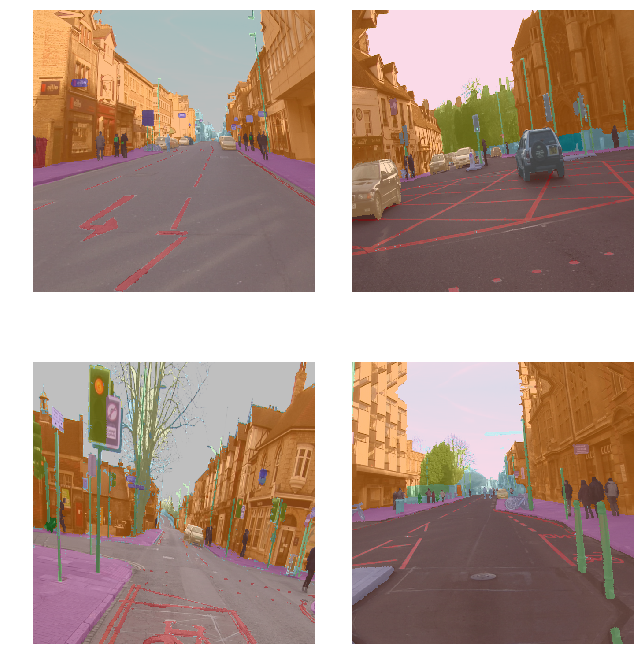

In [14]:
data.show_batch(2)

## Model

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
metrics=acc_camvid
# metrics=accuracy

In [17]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


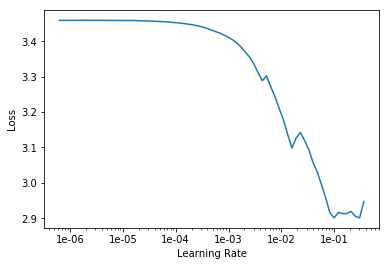

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr = 1e-2

In [20]:
learn.fit_one_cycle(5, slice(lr))

Total time: 02:09
epoch  train_loss  valid_loss  acc_camvid
1      1.060717    1.185129    0.737266    (00:26)
2      0.804764    0.754419    0.780789    (00:23)
3      0.665034    0.581383    0.846394    (00:30)
4      0.575189    0.580370    0.834029    (00:26)
5      0.518360    0.488941    0.859108    (00:22)



In [21]:
learn.fit_one_cycle(5, slice(lr))

Total time: 01:55
epoch  train_loss  valid_loss  acc_camvid
1      0.537176    0.525448    0.859031    (00:23)
2      0.594064    0.674190    0.833415    (00:23)
3      0.546736    0.465192    0.863655    (00:23)
4      0.482893    0.438947    0.874829    (00:23)
5      0.446391    0.394921    0.876998    (00:23)



In [22]:
learn.save('stage-1')

In [23]:
learn.load('stage-1')

In [24]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


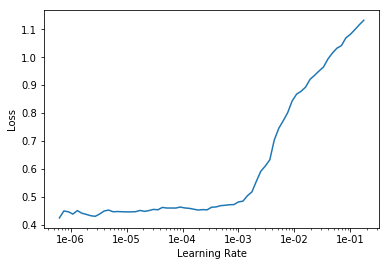

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(12, slice(1e-5,lr/5))

Total time: 05:08
epoch  train_loss  valid_loss  acc_camvid
1      0.455387    0.420266    0.871437    (00:29)
2      0.444265    0.429990    0.867998    (00:25)
3      0.446257    0.453032    0.863066    (00:25)
4      0.455828    0.449496    0.866556    (00:25)
5      0.425499    0.386069    0.877639    (00:25)
6      0.403312    0.400607    0.879523    (00:25)
7      0.387634    0.396535    0.880174    (00:25)
8      0.370230    0.401066    0.878059    (00:25)
9      0.351625    0.375585    0.889660    (00:25)
10     0.335057    0.404166    0.883582    (00:25)
11     0.336328    0.358214    0.891861    (00:25)
12     0.327895    0.360601    0.891927    (00:25)



In [27]:
learn.save('stage-2')

In [28]:
learn.load('stage-2')

In [29]:
learn.fit_one_cycle(12, slice(1e-5,lr/5))

Total time: 05:04
epoch  train_loss  valid_loss  acc_camvid
1      0.332193    0.377690    0.890475    (00:25)
2      0.335738    0.365893    0.890256    (00:25)
3      0.353297    0.404921    0.876506    (00:25)
4      0.356921    0.381672    0.889041    (00:25)
5      0.353242    0.381794    0.889481    (00:25)
6      0.333565    0.367144    0.896484    (00:25)
7      0.321953    0.349501    0.903559    (00:25)
8      0.303475    0.383256    0.902748    (00:25)
9      0.295121    0.330214    0.910169    (00:25)
10     0.280470    0.337768    0.906200    (00:25)
11     0.273752    0.333757    0.909218    (00:25)
12     0.277470    0.328253    0.909702    (00:25)



In [30]:
learn.save('stage-3')